In [1]:
import pandas as pd

In [17]:
data = pd.read_csv("pima-indians-diabetes.data.csv" , header=None, names=col_names)
df = data

In [18]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [20]:
df.shape

(768, 9)

In [21]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [22]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

models = {
    "SVM (RBF)": Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", probability=True, random_state=42))
    ]),
    "Naive Bayes (GaussianNB)": Pipeline([
        ("scaler", StandardScaler()),
        ("gnb", GaussianNB())
    ]),
    "Decision Tree": Pipeline([
        ("scaler", StandardScaler()),
        ("dt", DecisionTreeClassifier(random_state=42))
    ]),
    "KNN (k=5)": Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=5))
    ])
}



In [26]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)

results = []
probas = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Try to get predicted probabilities
    try:
        y_proba = model.predict_proba(X_test)[:,1]
    except Exception:
        y_proba = y_pred.astype(float)

    probas[name] = y_proba

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    })

In [27]:
metrics_df = pd.DataFrame(results).set_index("Model")
print("\nModel Performance Metrics:\n")
print(metrics_df)


Model Performance Metrics:

                          Accuracy  Precision    Recall  F1-score
Model                                                            
SVM (RBF)                 0.753247   0.687500  0.543210  0.606897
Naive Bayes (GaussianNB)  0.744589   0.641026  0.617284  0.628931
Decision Tree             0.761905   0.703125  0.555556  0.620690
KNN (k=5)                 0.714286   0.615385  0.493827  0.547945


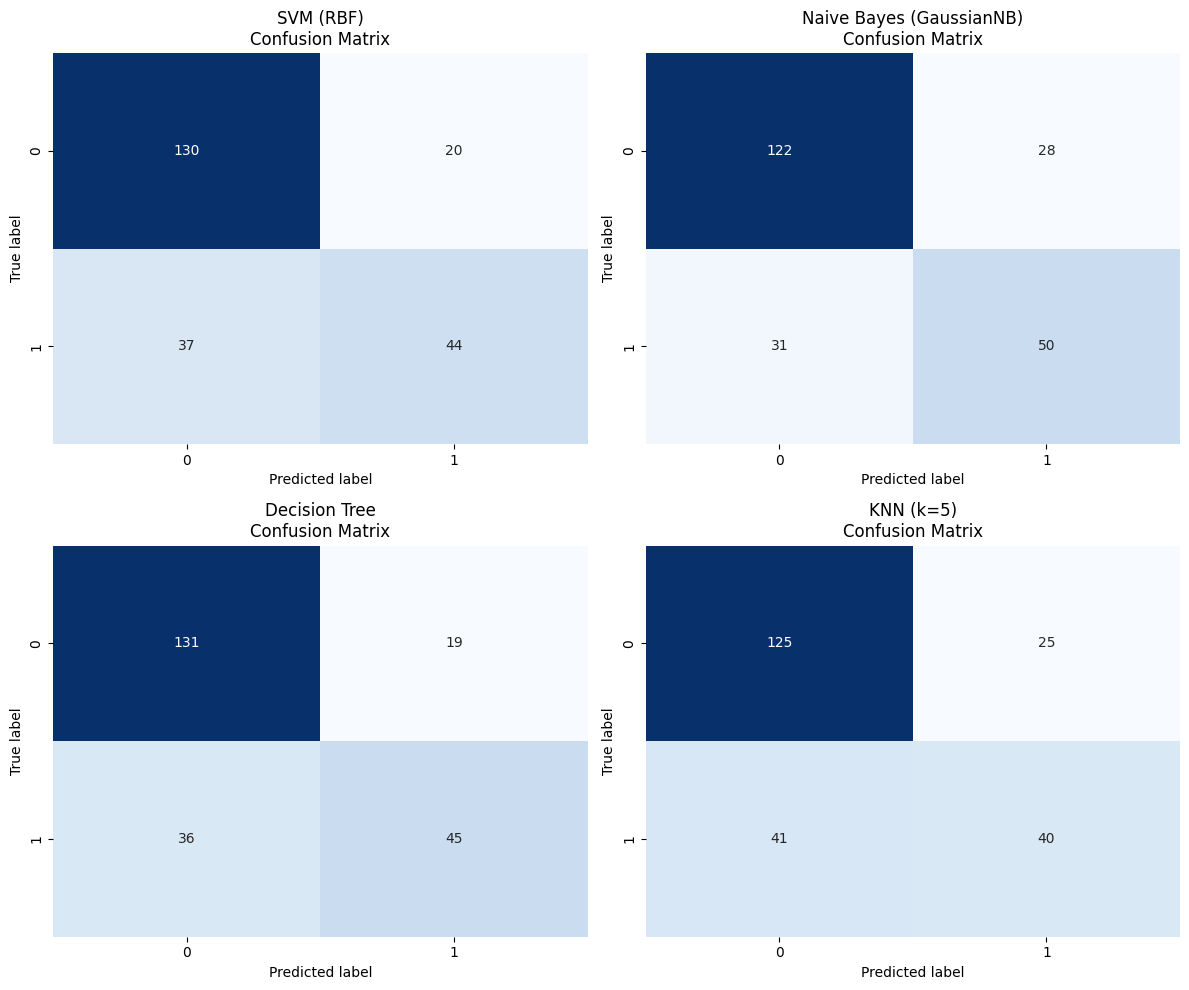

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.ravel()

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f"{name}\nConfusion Matrix")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

plt.tight_layout()
plt.show()

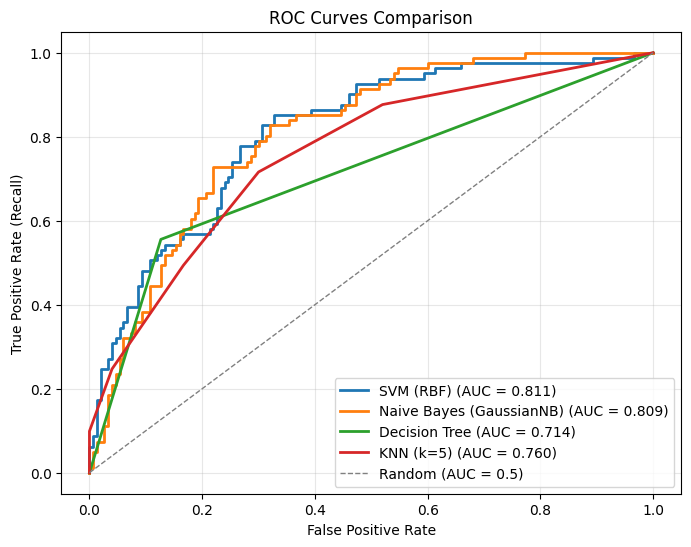

In [30]:
plt.figure(figsize=(8,6))

for name, y_proba in probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], linestyle='--', lw=1, color='gray', label="Random (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [31]:
import os

out_dir = "diabetes_model_plots"
os.makedirs(out_dir, exist_ok=True)

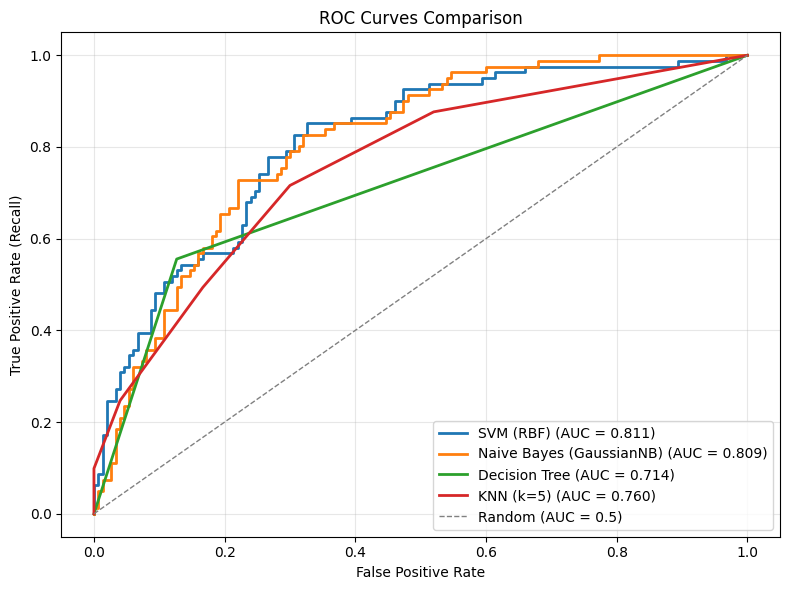


All plots saved in folder: diabetes_model_plots


In [32]:
plt.figure(figsize=(8,6))
for name, y_proba in probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle='--', lw=1, color='gray', label="Random (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "roc_comparison.png"), dpi=150)
plt.show()

print(f"\nAll plots saved in folder: {out_dir}")